# ECE 228 Project
## Tuberculosis Detection | Team 26
### Jianyu Tao
### Shreyas Borse
### Harshit Bhadani

In [1]:
%matplotlib inline

## Importing modules for necessary operations

import os
import shutil
import random
import torch
import torchvision
import numpy as np
import time
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import pdb
from PIL import Image
from matplotlib import pyplot as plt
import argparse
torch.manual_seed(0)

import torch.nn as nn
import torch.nn.functional as F

print('Using PyTorch version', torch.__version__)


from os.path import isfile
from os import rename
SMOOTH=1
import pdb
from sklearn.metrics import auc, roc_curve
from PIL.ImageFilter import GaussianBlur

# import pdb
from numpy import pi as PI
from numpy import sqrt
from scipy.special import comb
import math
import copy

Using PyTorch version 1.11.0


In [2]:
# Miscellaneous initialization
torch.manual_seed(1)
start_time = time.time()
parser = argparse.ArgumentParser()

In [3]:
train_dataset_path = ""
test_dataset_path = ""

In [4]:
root_dir = "/Users/harshitb/Desktop/Studies/ECE 228/TB_dataset/TB_Chest_Radiography_Database"
class_names = ['Normal', 'Tuberculosis']
source_dirs = ['Normal', 'Tuberculosis']

In [5]:
parser.add_argument('--num_epochs', type=int, default=5, help='Number of training epochs')
parser.add_argument('--batch_size', type=int, default=32, help='Batch size')
parser.add_argument('--lr', type=float, default=5e-4, help='Learning rate')
parser.add_argument('--l2', type=float, default=0, help='L2 regularisation')
parser.add_argument('--aug', action='store_true', default=False, help='Use data augmentation')
parser.add_argument('--data_path', type=str, default=root_dir,help='Path to data.')
parser.add_argument('--bond_dim', type=int, default=5, help='MPS Bond dimension')
parser.add_argument('--nChannel', type=int, default=1, help='Number of input channels')
parser.add_argument('--dense_net', action='store_true', default=False, help='Using Dense Net model')

args = parser.parse_args([])

In [6]:
batch_size = args.batch_size

# LoTeNet parameters
adaptive_mode = False 
periodic_bc   = False

kernel = 2 # Stride along spatial dimensions
output_dim = 1 # output dimension
 
feature_dim = 2

normTensor = 0.5*torch.ones(args.nChannel)
### Data processing and loading....


## Data Loading

In [7]:
### Data processing and loading....
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.Resize(size=(256,256)),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=normTensor,std=normTensor)])

valid_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(256,256)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=normTensor,std=normTensor)
    #torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225])
])

### Creating Datasets classes

In [8]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs,transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)}{class_name}')
            return images
        self.images={}
        self.class_names=['Normal', 'Tuberculosis']
        for c in self.class_names:
            self.images[c]=get_images(c)
        self.image_dirs=image_dirs
        self.transform=transform
        
    
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    def __getitem__(self, index):
        class_name=random.choice(self.class_names)
        index=index%len(self.images[class_name])
        image_name=self.images[class_name][index]
        image_path =os.path.join(self.image_dirs[class_name], image_name)
        image=Image.open(image_path).convert('L')
        return self.transform(image), self.class_names.index(class_name)

In [9]:
train_dirs = {
    'Normal': root_dir + '/Normal',
    'Tuberculosis': root_dir + '/Tuberculosis'
}
dataset = ChestXRayDataset(train_dirs, train_transform)

Found 3500Normal
Found 700Tuberculosis


In [10]:
trainset, testset, valset = random_split(dataset, [3300, 600, 300])

In [11]:
train_loader =  torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader =  torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

# Creating various architectures

In [12]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        #         xl = 1
        #         for i in x.shape[1:]: xl *= i
        #         self.fc1 = nn.Linear(13456, 120)
        self.fc1 = nn.Linear(984064, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        # -> n, 3, 32, 32
        #         x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        #         x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv1(x))  # -> n, 6, 14, 14
        x = F.relu(self.conv2(x))
        xl = 1
        for i in x.shape[1:]: xl *= i
        x = x.view(-1, xl)            # 
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 2
        return x

In [13]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(59536, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, 2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [14]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(32768, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 2)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
#         print("HERE ... ", x.shape)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x

In [15]:
# Initialising variable that will be used in the experiments in the project

loss_data_of_model_epoch = {}
acc_of_model_epoch = {}
acc_of_model_batch = {}

all_models = {}
all_models['ConvNet'] = ConvNet()
all_models['LeNet5']  = LeNet5()
all_models['VGG16']   = VGG16()

for model_name in all_models.keys():
    loss_data_of_model_epoch[model_name] = {}
    acc_of_model_epoch[model_name] = {}
    acc_of_model_batch[model_name] = {}

LeNet5_model_with_epoch = {}

# Defining various functions to make the code modular

In [16]:
def get_acc_from_data(d_loader):
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(2)]
        n_class_samples = [0 for i in range(2)]
        for images, labels in d_loader:
            #         print(len(labels))
            outputs = model(images)
            # max returns (value ,index)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            for i in range(len(labels)):
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {acc} %')
        
        all_acc = []
        overall_accuracy = acc
        all_acc.append(overall_accuracy)

        for i in range(2):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {class_names[i]}: {acc} %')
            all_acc.append(acc)
                
    #return all_acc
    return overall_accuracy
    

In [17]:

def train_by_model(model, model_name, epo = 3, verbose = True):
    args.num_epochs = epo
    learning_rate = 0.001
    all_loss = []

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    n_total_steps = len(train_loader)
    for epoch in range(args.num_epochs):
        for i, (images, labels) in enumerate(train_loader):

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            all_loss.append(loss.item())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if ((i+1) % 10 == 0) and verbose:
                print (f'Epoch [{epoch+1}/{args.num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            
        LeNet5_model_with_epoch[epoch+1] = copy.deepcopy(model)
        
    return all_loss

# Experiments

### Experiment: Deciding Architecture

In [18]:
# Checking various architectures above one by one with epoch = 3

model_name = "LeNet5"
model = all_models[model_name]

train_by_model(model, model_name)
get_acc_from_data(test_loader)

Epoch [1/3], Step [10/104], Loss: 0.6480
Epoch [1/3], Step [20/104], Loss: 0.6886
Epoch [1/3], Step [30/104], Loss: 0.6137
Epoch [1/3], Step [40/104], Loss: 0.5863
Epoch [1/3], Step [50/104], Loss: 0.5662
Epoch [1/3], Step [60/104], Loss: 0.5802
Epoch [1/3], Step [70/104], Loss: 0.5153
Epoch [1/3], Step [80/104], Loss: 0.5824
Epoch [1/3], Step [90/104], Loss: 0.4819
Epoch [1/3], Step [100/104], Loss: 0.5105
Epoch [2/3], Step [10/104], Loss: 0.4502
Epoch [2/3], Step [20/104], Loss: 0.3972
Epoch [2/3], Step [30/104], Loss: 0.4069
Epoch [2/3], Step [40/104], Loss: 0.4233
Epoch [2/3], Step [50/104], Loss: 0.4262
Epoch [2/3], Step [60/104], Loss: 0.3951
Epoch [2/3], Step [70/104], Loss: 0.5174
Epoch [2/3], Step [80/104], Loss: 0.4019
Epoch [2/3], Step [90/104], Loss: 0.3183
Epoch [2/3], Step [100/104], Loss: 0.3372
Epoch [3/3], Step [10/104], Loss: 0.5151
Epoch [3/3], Step [20/104], Loss: 0.2521
Epoch [3/3], Step [30/104], Loss: 0.3850
Epoch [3/3], Step [40/104], Loss: 0.3334
Epoch [3/3], S

87.16666666666667

### Experiment: Deciding epoch

Calculating accuracy of model with epoch:  1
Accuracy of the network: 82.66666666666667 %
Accuracy of Normal: 69.01408450704226 %
Accuracy of Tuberculosis: 94.9367088607595 %
Calculating accuracy of model with epoch:  2
Accuracy of the network: 85.16666666666667 %
Accuracy of Normal: 92.98245614035088 %
Accuracy of Tuberculosis: 78.0952380952381 %
Calculating accuracy of model with epoch:  3
Accuracy of the network: 88.0 %
Accuracy of Normal: 83.7748344370861 %
Accuracy of Tuberculosis: 92.28187919463087 %
Calculating accuracy of model with epoch:  4
Accuracy of the network: 87.16666666666667 %
Accuracy of Normal: 81.92771084337349 %
Accuracy of Tuberculosis: 93.65671641791045 %
Calculating accuracy of model with epoch:  5
Accuracy of the network: 91.33333333333333 %
Accuracy of Normal: 90.64516129032258 %
Accuracy of Tuberculosis: 92.06896551724138 %
Calculating accuracy of model with epoch:  6
Accuracy of the network: 88.66666666666667 %
Accuracy of Normal: 95.66666666666667 %
Accura

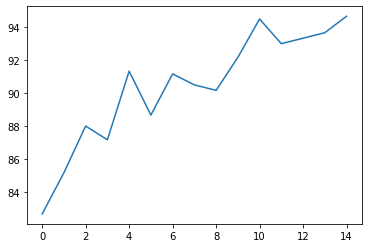

In [19]:
%%time
# Accuracy for LeNet5 with various epoch

model = LeNet5()
model_name = "LeNet5"

losses = train_by_model(model, model_name, 15, verbose = False)

accs = {}
for epo in LeNet5_model_with_epoch:
    print("Calculating accuracy of model with epoch: ", epo)
    model = LeNet5_model_with_epoch[epo]
    acc = get_acc_from_data(test_loader)
    accs[epo] = acc

acc_of_model_epoch[model_name] = accs

# -----------------------------------------------------
import json
with open('loss_data_of_model_epoch.json', 'w') as fp:
    json.dump(loss_data_of_model_epoch, fp)
    
with open('acc_of_model_epoch.json', 'w') as fp:
    json.dump(acc_of_model_epoch, fp)
# -----------------------------------------------------

model_name = "LeNet5"
max_acc_epo = 1
max_acc = acc_of_model_epoch[model_name][max_acc_epo]
for epo in acc_of_model_epoch[model_name]:
    if max_acc < acc_of_model_epoch[model_name][epo]:
        max_acc = acc_of_model_epoch[model_name][epo]
        max_acc_epo = epo

print("Maximum accuracy is ", max_acc, " with epoch as ", max_acc_epo)

plt.plot(list(accs.values()))

### Experiment: Deciding batch size

In [20]:
%%time

# Experiment with various batch sizes for LeNet5 with epoch = 5


for bs in [16, 32, 64]:
    print("Batch Size: ", bs)
    train_loader =  torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True)
    test_loader =  torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=True)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=bs, shuffle=True)
    model = LeNet5()
    train_by_model(model, model_name, 5, verbose = False)
    acc_of_model_batch[model_name][bs] = get_acc_from_data(test_loader)

Batch Size:  16
Accuracy of the network: 92.33333333333333 %
Accuracy of Normal: 87.27915194346289 %
Accuracy of Tuberculosis: 96.84542586750788 %
Batch Size:  32
Accuracy of the network: 91.16666666666667 %
Accuracy of Normal: 94.49838187702265 %
Accuracy of Tuberculosis: 87.62886597938144 %
Batch Size:  64
Accuracy of the network: 85.5 %
Accuracy of Normal: 80.85106382978724 %
Accuracy of Tuberculosis: 89.62264150943396 %
CPU times: user 25min 39s, sys: 23 s, total: 26min 2s
Wall time: 21min 16s


In [21]:
# Getting Batch Size that gives highest accuracy

model_name = "LeNet5"
max_acc_bat = 16
max_acc = acc_of_model_batch[model_name][max_acc_bat]
for bat in acc_of_model_batch[model_name]:
    if max_acc < acc_of_model_batch[model_name][bat]:
        max_acc = acc_of_model_batch[model_name][bat]
        max_acc_bat = bat 

print("Maximum accuracy is ", max_acc, " with batch size as ", max_acc_bat)

print("Upon analyzing the runtime and accuracy of data we took the following parameters forward")
print("Batch Size: 32")
print("32 was taken as it had lesser runtime")

Maximum accuracy is  92.33333333333333  with batch size as  16
Upon analyzing the runtime and accuracy of data we took the following parameters forward
Batch Size: 32
32 was taken as it had lesser runtime


# Conclusion

In [22]:
args.num_epochs = 12
batch_size = 32

train_loader =  torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader =  torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

model = LeNet5()
model_name = "LeNet5"

losses = train_by_model(model, model_name, args.num_epochs)

Epoch [1/12], Step [10/104], Loss: 0.6950
Epoch [1/12], Step [20/104], Loss: 0.6530
Epoch [1/12], Step [30/104], Loss: 0.6434
Epoch [1/12], Step [40/104], Loss: 0.6155
Epoch [1/12], Step [50/104], Loss: 0.6079
Epoch [1/12], Step [60/104], Loss: 0.6001
Epoch [1/12], Step [70/104], Loss: 0.5416
Epoch [1/12], Step [80/104], Loss: 0.5198
Epoch [1/12], Step [90/104], Loss: 0.5263
Epoch [1/12], Step [100/104], Loss: 0.5246
Epoch [2/12], Step [10/104], Loss: 0.4880
Epoch [2/12], Step [20/104], Loss: 0.4697
Epoch [2/12], Step [30/104], Loss: 0.4443
Epoch [2/12], Step [40/104], Loss: 0.4804
Epoch [2/12], Step [50/104], Loss: 0.4150
Epoch [2/12], Step [60/104], Loss: 0.4457
Epoch [2/12], Step [70/104], Loss: 0.4531
Epoch [2/12], Step [80/104], Loss: 0.3649
Epoch [2/12], Step [90/104], Loss: 0.3435
Epoch [2/12], Step [100/104], Loss: 0.4396
Epoch [3/12], Step [10/104], Loss: 0.3599
Epoch [3/12], Step [20/104], Loss: 0.2382
Epoch [3/12], Step [30/104], Loss: 0.3944
Epoch [3/12], Step [40/104], Los

In [23]:
get_acc_from_data(test_loader)

Accuracy of the network: 91.5 %
Accuracy of Normal: 86.62207357859532 %
Accuracy of Tuberculosis: 96.34551495016612 %


91.5

In [24]:
get_acc_from_data(val_loader)

Accuracy of the network: 95.66666666666667 %
Accuracy of Normal: 92.46575342465754 %
Accuracy of Tuberculosis: 98.7012987012987 %


95.66666666666667